<a href="https://colab.research.google.com/github/khencohen/HyperspectralDetection/blob/main/hyper_ssce.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
## imports

import matplotlib.pyplot as plt
import numpy as np
import torch
from scipy.io import loadmat
from sklearn import metrics
from torch import nn
import torch.nn.functional as F
# import wandb
from sklearn.cluster import KMeans
from scipy.linalg import sqrtm
from sklearn.decomposition import PCA
torch.manual_seed(1)
from tqdm import tqdm
from sklearn.covariance import LedoitWolf
from google.colab import drive
drive.mount('/content/drive')
homedir = 'drive/MyDrive'

Mounted at /content/drive


In [ ]:
## load data and target


device = 'cuda' if torch.cuda.is_available() else 'cpu'
# homedir = '.'
# X = loadmat(f'{homedir}/data/PaviaU.mat')['paviaU']
# target = np.load(f'{homedir}/data/plastic.npy')

X = loadmat(f'{homedir}/data/PaviaU.mat')['paviaU']
target = np.load(f'{homedir}/data/plastic.npy')



X = (X / X.mean())
X = X[200:400, 100:300]

# theta = theta.reshape(-1)
# tot_size = len(theta)
channels = X.shape[2]
d = channels

use_pca=False

if use_pca:
  pca = PCA(n_components=10).fit(X.reshape(-1, channels))
  X = pca.transform(X.reshape(-1,channels)).reshape(X.shape[0], X.shape[1],-1)
  channels = X.shape[2]
  d = channels


# sample_cov = np.cov(X.reshape(-1, d).T)
# scov = sqrtm(sample_cov)
# K = len(np.unique(theta))

target = target / np.mean(target) * 2

X = torch.from_numpy(X).float()

target = torch.from_numpy(target).float()

alpha = 0.2

target_location = 1 - (torch.rand(X.shape[0], X.shape[1], 1) > 0.001).float()
center_mask = torch.zeros(X.shape[0], X.shape[1], 1)
center_mask[20:-20, 20:-20] = 1
target_location = target_location * center_mask
alpha_t = target_location * alpha
X_with_targets = (1 - alpha_t) * X + alpha_t * target.reshape(1, 1, channels) #replacemnet model
# X_with_targets = X + alpha_t * target.reshape(1, 1, channels) # addtive model


all_inds_in_center = torch.where(center_mask.flatten())[0]
all_inds_in_center = all_inds_in_center[torch.randperm(len(all_inds_in_center))]
train_inds, test_inds = all_inds_in_center[:int(len(all_inds_in_center) * 0.8)], all_inds_in_center[
                                                                                 int(len(all_inds_in_center) * 0.8):]


In [ ]:
## generate data functions

def generate_data_single(x, inds=None):
    half_window_size = 5
    if inds == 'train':
        flatten_inds = np.random.choice(train_inds, 1)[0]
    elif inds =='test':
        flatten_inds = np.random.choice(test_inds, 1)[0]
    else:
        flatten_inds = inds
    center_ind_x, center_ind_y = flatten_inds // x.shape[1], flatten_inds % x.shape[1]
    if center_ind_x < half_window_size + 1 or center_ind_x > x.shape[
        0] - half_window_size - 1 or center_ind_y < half_window_size + 1 or center_ind_y > x.shape[
        1] - half_window_size - 1:
        x_local_flatten = torch.zeros((2 * half_window_size + 1, 2 * half_window_size + 1, channels)).reshape(-1,
                                                                                                              channels)
        y = torch.zeros(channels)
    else:
        inds_x = center_ind_x + torch.arange(-half_window_size, half_window_size + 1)
        inds_y = center_ind_y + torch.arange(-half_window_size, half_window_size + 1)
        x_local = x[inds_x][:, inds_y]
        x_local_flatten = flatten_tensor_by_distance(x_local.permute(2, 0, 1)).permute(1, 0)
        y = x_local_flatten[0]
    return x_local_flatten, y


def generate_data_batch(x, batch_size, inds=None):
    xs, ys = zip(*[generate_data_single(x, inds=inds) for _ in range(batch_size)])
    xs = torch.stack(xs, 0)
    ys = torch.stack(ys, 0)
    return xs, ys


def generate_data_batch_inds(x, all_inds):
    xs, ys = zip(*[generate_data_single(x, inds=inds) for inds in all_inds])
    xs = torch.stack(xs, 0)
    ys = torch.stack(ys, 0)
    return xs, ys



def flatten_tensor_by_distance(tensor):
    n = tensor.size(1)
    center = (n - 1) / 2  # Center position for odd-sized tensors

    # Create a tensor of indices
    indices = torch.cartesian_prod(torch.arange(n), torch.arange(n))

    # Calculate distances from the center for each index
    distances = torch.norm(indices - center, dim=1)

    # Sort indices based on distances
    _, sorted_indices = torch.sort(distances)

    # Flatten the tensor using the sorted indices for dimensions 1 and 2
    flattened_tensor = tensor.reshape(tensor.shape[0], -1)[:, sorted_indices]
    return flattened_tensor


## classes for the detectors (MF, AMF, ace ...)

class MF:
    def __init__(self, name):
        self.name = name

    def __call__(self, x, target, alg='MF', use_cov=False):
        self.reconstruct(x)
        x_reconstructed = self.x_recunstructed

        x_reduced_mean = x - x_reconstructed

        if use_cov == 'before':
            cov = torch.cov(x.reshape(-1, channels).T)
        elif use_cov == 'after':
            cov = torch.cov(x_reduced_mean.reshape(-1, channels).T)
        else:
            cov = torch.eye(channels)

        inv_cov = torch.linalg.inv(cov) + 1e-3 * torch.eye(d)

        target = target.reshape(1, 1, 1, channels)
        inv_cov = inv_cov.reshape(1, 1, channels, channels)
        x_reduced_mean = x_reduced_mean.reshape(x.shape[0], x.shape[1], channels, 1)
        if alg == 'MF':
            score = target @ inv_cov @ x_reduced_mean
        elif alg == 'AMF' or alg == 'AMF_pos':
            score = (target @ inv_cov @ x_reduced_mean) **2 / (target @ inv_cov @ target.swapaxes(3, 2))
            if alg == 'AMF_pos':
                score = score * torch.sign(target @ inv_cov @ x_reduced_mean)
        elif alg == 'ace' or alg == 'ace_pos':
            score = (target @ inv_cov @ x_reduced_mean) ** 2 / ((
                        x_reduced_mean.swapaxes(3, 2) @ inv_cov @ x_reduced_mean))
            if alg == 'ace_pos':
                score = score * torch.sign(target @ inv_cov @ x_reduced_mean)
        score = score.reshape(x.shape[0], x.shape[1], 1)
        self.loglike = loglike(x, x_reconstructed, inv_cov, center_mask = center_mask)
        return score

    def calc_inv_cov(self, x):
        self.reconstruct(x)
        x_reconstructed = self.x_recunstructed
        x_reduced_mean = x - x_reconstructed
        cov = torch.cov(x_reduced_mean.reshape(-1, channels).T)
        inv_cov = torch.linalg.inv(cov)

        return inv_cov

    def reconstruct(self, x):
        raise NotImplementedError


class MFKmeans(MF):

    def reconstruct(self, x):
        kmeans = KMeans(n_clusters=10, random_state=0).fit(x.reshape(-1, channels))

        clusters = kmeans.predict(x.reshape(-1, channels))

        clusters = clusters.reshape(X_with_targets.shape[0], X_with_targets.shape[1])
        clusters = torch.from_numpy(clusters).long()

        means = torch.from_numpy(kmeans.cluster_centers_).float()

        means_k = torch.zeros_like(X_with_targets)
        for i in range(len(means)):
            means_k[clusters == i] = means[i]
        self.x_recunstructed = means_k
        self.rec_score = rec_score(x, self.x_recunstructed)

        return means_k


def rec_score(x, x_recunstructed):
    score = torch.mean((x_recunstructed - x) ** 2 * center_mask)
    return score


print(1)


class MFGlobal(MF):
    def __init__(self, name, use_cov=False):
        self.name = name
        self.use_cov = use_cov

    def reconstruct(self, x):
        mean = torch.mean(x, (0, 1))
        x_recunstructed = torch.ones_like(x) * mean[None, None]
        self.x_recunstructed = x_recunstructed
        self.rec_score = rec_score(x, x_recunstructed)


class MFlocalMean(MF):
    def __init__(self, name, half_window_size=5, use_cov=False):
        self.name = name
        self.use_cov = use_cov
        self.half_window_size = half_window_size
        self.kernel = torch.ones(1, 1, 1, half_window_size * 2 + 1, half_window_size * 2 + 1) / (
                    (half_window_size * 2 + 1) ** 2 - 1)
        self.kernel[:, :, :, half_window_size, half_window_size] = 0

    def reconstruct(self, x):
        x = x[None, None]
        x = x.permute(0, 1, 4, 2, 3)
        local_mean = F.conv3d(x, self.kernel, padding=(0, self.half_window_size, self.half_window_size))
        x_recunstructed = local_mean[0, 0].permute(1, 2, 0)
        x = x[0, 0].permute(1, 2, 0)
        self.x_recunstructed = x_recunstructed
        self.rec_score = rec_score(x, x_recunstructed)



class MFNet(MF):
    def __init__(self, name, model):
        self.name = name
        self.model = model
        self.x_recunstructed = None

    def reconstruct(self, x):
        if self.x_recunstructed is not None:
            return
        inds = torch.chunk(torch.arange(len(x.reshape(-1, channels))), 500)
        # Net_mean = torch.zeros_like(x).reshape(-1, channels)
        Net_mean = []
        for ind in tqdm(inds):
            xi, yi = generate_data_batch_inds(x, ind)
            Net_mean.append(self.model(xi.to(device))[0].cpu().detach())
        Net_mean = torch.cat(Net_mean, 0)
        Net_mean = Net_mean.reshape(x.shape)
        x_recunstructed = Net_mean
        self.x_recunstructed = x_recunstructed
        self.rec_score = rec_score(x, x_recunstructed)





class MFNetCov(MF):
    def __init__(self, name, model):
        self.name = name
        self.model = model
        self.x_recunstructed = None

    def reconstruct(self, x):
        if self.x_recunstructed is not None:
            return
        inds = torch.chunk(torch.arange(len(x.reshape(-1, channels))), 500)
        # Net_mean = torch.zeros_like(x).reshape(-1, channels)
        Net_mean = []
        for ind in tqdm(inds):
            xi, yi = generate_data_batch_inds(x, ind)
            Net_mean.append(self.model(xi.to(device))[0].cpu().detach())
        Net_mean = torch.cat(Net_mean, 0)
        Net_mean = Net_mean.reshape(x.shape)
        x_recunstructed = Net_mean
        self.x_recunstructed = x_recunstructed
        self.rec_score = rec_score(x, x_recunstructed)
        self.inv_cov = self.model(xi[:1].to(device))[1].cpu().detach()

    def __call__(self, x, target, alg='MF', use_cov=False):
        self.reconstruct(x)
        x_reconstructed = self.x_recunstructed

        x_reduced_mean = x - x_reconstructed

        inv_cov = self.inv_cov

        target = target.reshape(1, 1, 1, channels)
        inv_cov = inv_cov.reshape(1, 1, channels, channels)
        x_reduced_mean = x_reduced_mean.reshape(x.shape[0], x.shape[1], channels, 1)
        if alg == 'MF':
            score = target @ inv_cov @ x_reduced_mean
        elif alg == 'AMF' or alg == 'AMF_pos':
            score = (target @ inv_cov @ x_reduced_mean) **2 / (target @ inv_cov @ target.swapaxes(3, 2))
            if alg == 'AMF_pos':
                score = score * torch.sign(target @ inv_cov @ x_reduced_mean)
        elif alg == 'ace' or alg == 'ace_pos':
            score = (target @ inv_cov @ x_reduced_mean) ** 2 / ((
                        x_reduced_mean.swapaxes(3, 2) @ inv_cov @ x_reduced_mean))
            if alg == 'ace_pos':
                score = score * torch.sign(target @ inv_cov @ x_reduced_mean)
        score = score.reshape(x.shape[0], x.shape[1], 1)
        self.loglike = loglike(x, x_reconstructed, inv_cov,center_mask=center_mask)
        return score
        return score



## DNNs

hidden_size = 100
hidden_K = 10
#


hidden_size_encoder = 20
v_size = 100

hidden_conv = 20


class ConvNet(nn.Module):
    def __init__(self, output_size=100):
        super().__init__()
        self.conv1 = nn.Conv1d(1, hidden_conv, 3)
        self.conv2 = nn.Conv1d(hidden_conv, hidden_conv, 3, stride=2)
        self.conv3 = nn.Conv1d(hidden_conv, hidden_conv, 3)
        self.fc1 = nn.Linear(960, output_size)
        self.relu = nn.ReLU()

    def forward(self, x):
        org_shape = x.shape
        x = x.reshape(org_shape[0], 1, -1)
        x = self.conv1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.relu(x)
        x = self.conv3(x)
        x = self.relu(x)
        x = x.reshape(org_shape[0], -1)
        x = self.fc1(x)
        x = x.reshape(-1)
        return x


class Net(nn.Module):
    def __init__(self):
        super().__init__()
        # self.means = torch.nn.Parameter(torch.randn(hidden_K, d))
        # self.means.requires_grad = True
        # self.fc_encoder = nn.Linear(channels, hidden_size_encoder)
        self.fc_encoder = ConvNet(output_size=hidden_size_encoder)
        # self.fc_encoder_v = nn.Linear(channels, v_size)
        self.fc_encoder_v = ConvNet(output_size=v_size)
        self.fc_decoder = nn.Linear(v_size, channels, bias=False)
        # self.fc_decoder.weight.data = means
        self.relu = nn.ReLU()
        self.sinvcov = torch.nn.Parameter(torch.randn(1, d, d))
        self.sinvcov.requires_grad = True

    # def forward(self, x):
    #     batch_size, window_size, d = x.shape
    #     x_flatten = x.reshape(-1 , d)
    #     encoded_x = self.fc_encoder(x_flatten)
    #     encoded_xv = self.fc_encoder_v(x_flatten)
    #     encoded_x = encoded_x.reshape(batch_size, window_size, hidden_size_encoder)
    #     encoded_xv = encoded_xv.reshape(batch_size, window_size, v_size)
    #     encoded_x_center = encoded_x[:,0:1, :]
    #     encoded_x_reference = encoded_x[:,1:,:]
    #     weights = encoded_x_center @ encoded_x_reference.swapaxes(2,1)
    #     weights = nn.Softmax(2)(weights)
    #     weights = weights.swapaxes(2,1)
    #     total_encoded = torch.sum(encoded_xv[:,1:] * weights, 1)
    #     decoded = self.fc_decoder(total_encoded)

    #     return decoded
    def forward(self, x):
        batch_size, window_size, d = x.shape
        x_flatten = x.reshape(-1, d)
        encoded_x = self.fc_encoder(x_flatten)
        encoded_xv = self.fc_encoder_v(x_flatten)
        encoded_x = encoded_x.reshape(batch_size, window_size, hidden_size_encoder)
        encoded_xv = encoded_xv.reshape(batch_size, window_size, v_size)
        encoded_x_center = encoded_x[:, 1:5, :]
        encoded_x_reference = encoded_x[:, 1:, :]
        weights = encoded_x_center @ encoded_x_reference.swapaxes(2, 1)
        weights = nn.Softmax(2)(weights)
        weights = weights.swapaxes(2, 1)
        total_encoded = torch.sum(weights[:, :, None] * encoded_xv[:, 1:, :, None], 1)
        total_encoded = torch.mean(total_encoded, -1)
        decoded = self.fc_decoder(total_encoded)
        inv_cov = self.sinvcov @ self.sinvcov.swapaxes(2, 1) + 1e-6 * torch.eye(d).to(device)
        return decoded, inv_cov


def loss_fn(y, yhat):
    return torch.mean((y - yhat) ** 2)


def loglike(y, yhat, inv_cov, center_mask=None):
    y = y.reshape(-1, channels)
    yhat = yhat.reshape(-1, channels)
    if center_mask is not None:
      center_mask = center_mask.reshape(-1)
      y = y[center_mask==1]
      yhat = yhat[center_mask==1]
    inv_cov = inv_cov.reshape(-1, channels, channels)
    return torch.mean(-(y - yhat)[:, None, :] @ inv_cov @ (y - yhat)[:, :, None] + torch.logdet(inv_cov))




1


In [ ]:
## train DNNs

net = Net().to(device)
net_cov = Net().to(device)

test_size = 1000

x_test, y_test = generate_data_batch(X_with_targets, test_size, inds='test')

## DNN of mean and cov

lr = 1e-4


optimizer = torch.optim.Adam(lr=lr, params=net_cov.parameters())
schedular = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=2, verbose=True, factor=0.5)

iters = 50000
# iters = 0
log_iter = 1000
batch_size = 1

lossses = []

stop = False

for it in range(iters):
    optimizer.zero_grad()
    x, y = generate_data_batch(X_with_targets, batch_size, inds='train')
    yhat, inv_cov = net_cov(x.to(device))
    loss = -loglike(yhat, y.to(device), inv_cov)
    loss.backward()
    optimizer.step()
    lossses.append(loss.item())
    if np.mod(it, log_iter) == 0:
        yhat_test, inv_cov_test = net_cov(x_test.to(device))
        loss_test = - loglike(yhat_test, y_test.to(device), inv_cov_test).item()
        rec_err = loss_fn(yhat_test, y_test.to(device)).item()

        loss_train = np.mean(lossses)
        schedular.step(loss_train)
        print(it, loss_train, loss_test, rec_err)
        lossses = []

    if stop:
        break

## DNN of only mean


lr = 1e-4

optimizer = torch.optim.Adam(lr=lr, params=net.parameters())
schedular = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=2, verbose=True, factor=0.5)

iters = 50000
# iters = 0
log_iter = 1000
batch_size = 1

lossses = []

stop = False

for it in range(iters):
    optimizer.zero_grad()
    x, y = generate_data_batch(X_with_targets, batch_size, inds='train')
    yhat, _ = net(x.to(device))
    loss = loss_fn(yhat, y.to(device))
    loss.backward()
    optimizer.step()
    lossses.append(loss.item())
    if np.mod(it, log_iter) == 0:
        yhat_test, _ = net(x_test.to(device))
        loss_test = loss_fn(yhat_test, y_test.to(device)).item()
        loss_train = np.mean(lossses)
        schedular.step(loss_train)
        print(it, loss_train, loss_test)
        lossses = []

    if stop:
        break

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


0 15467.708984375 14132.66796875 1.3804453611373901
1000 1902.5192445373534 615.7489013671875 0.31465214490890503
2000 228.7316474304199 46.17896270751953 0.23143735527992249
3000 60.09451649475098 -89.14318084716797 0.21206004917621613
4000 -72.64997035217286 -147.2976837158203 0.19663479924201965
5000 -133.29648065185546 -237.75650024414062 0.18646183609962463
6000 -232.94656240844728 -222.73597717285156 0.1822672337293625
7000 -253.9713357696533 -288.9818420410156 0.16477201879024506
8000 -274.335818069458 -319.8343505859375 0.17095619440078735
9000 -313.956398361206 -316.2336730957031 0.16666677594184875
10000 -324.484602355957 -315.6008605957031 0.173722505569458
11000 -336.330262008667 -291.08489990234375 0.1549888551235199
12000 -345.7764415130615 -354.94061279296875 0.1644122302532196
13000 -348.5676760406494 -366.69287109375 0.17337679862976074
14000 -362.13728604125976 -368.9454040527344 0.18107986450195312
15000 -367.8246664428711 -372.68780517578125 0.16289855539798737
1600

100%|██████████| 500/500 [11:03<00:00,  1.33s/it]


mf_net_after loglike -2494.36572265625


100%|██████████| 500/500 [11:05<00:00,  1.33s/it]


mf_net_cov_after loglike -12340.6123046875
mf_local_mean_global_cov_after loglike 792.4428100585938


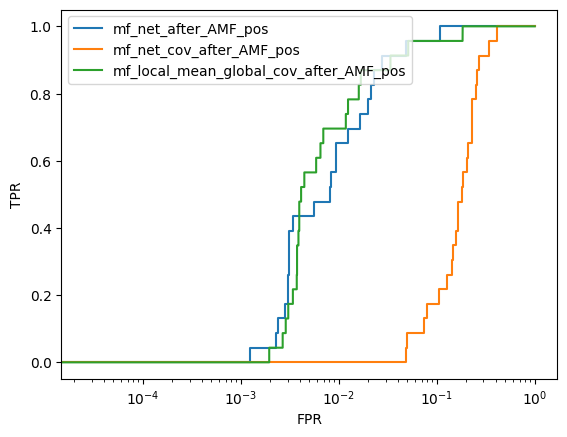

{'mf_net': 0.9162883758544922, 'mf_net_cov': 0.9222577214241028, 'mf_local_mean_global_cov': 0.10358858108520508}
-2496.228515625


In [ ]:
## evaluate detectors

fpr = {}
tpr = {}
tr = {}
yhat = {}
rec_scores = {}
loglikes = {}


net = Net().to(device)
net_cov = Net().to(device)

test_size = 100

x_test, y_test = generate_data_batch(X_with_targets, test_size, inds='test')


mf_global_cov = MFGlobal('mf_global_cov')
mf_local_mean_global_cov = MFlocalMean('mf_local_mean_global_cov', half_window_size=10)
mf_kmeans = MFKmeans('mf_kemans')
mf_net = MFNet('mf_net', model=net)
mf_net_cov = MFNetCov('mf_net_cov', model=net_cov)

models = [mf_net, mf_net_cov, mf_local_mean_global_cov]
# models =  [mf_local_mean_global_cov]
# models = [mf_global_cov, mf_local_mean_global_cov, mf_kmeans]
# models = [mf_kmeans]


use_covs = ['after']
# use_covs = ['after']
algs = ['AMF_pos']

for model in models:
    model_name = model.name
    for alg in algs:
        for use_cov in use_covs:
            act_str = '_' + use_cov + '_' + alg
            # act_str = '_' + use_cov
            name = model_name + act_str
            yhat[name] = model(X_with_targets, target, use_cov=use_cov, alg=alg)
            yhat[name] -= torch.min(yhat[name]) + 1
            yhat[name] *= center_mask
            fpr[name], tpr[name], tr[name] = metrics.roc_curve(target_location.flatten().numpy(),
                                                               yhat[name].flatten().numpy())
            plt.plot(fpr[name], tpr[name], label=name)
            plt.xscale('log')
            rec_scores[model_name] = model.rec_score.item()
            loglikes[model_name] = model.loglike.item()
            plt.xlabel('FPR')
            plt.ylabel('TPR')
            # print(model_name, 'rec_score', model.rec_score.item())
            print(model_name +'_' +use_cov, 'loglike', model.loglike.item())

plt.legend()
plt.show()
print(rec_scores)
inv_cov_net =  mf_net.calc_inv_cov(X_with_targets)
yhat_test, _ = net(x_test.to(device))
print(loglike(yhat_test, y_test.to(device), inv_cov_net.to(device)).item())